# Fit of an enhanced SVM


In [1]:
import os.path as osp

In [2]:
path = '../'
dir_figs = osp.join(path, 'dir_figs')

In [3]:
import sys
sys.path.append(path)

In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings


import scipy
from scipy import stats
import seaborn as sns

import copy

import abc
import pandas as pd
from typing import Dict, Any



from src.download_data.financial_data import get_sp_500
from src.download_data.simulated_data import simulate_data
from src.tools.timer import timeit


warnings.filterwarnings("ignore")
sns.set()

# Parameters

In [6]:
# size of the time series
T = 1_000

# Download data

In [7]:
df = get_sp_500(T = T, log_returns = True, freq = 1)
df.head()

[*********************100%***********************]  1 of 1 completed


Date
1993-02-02 00:00:00-05:00    0.002116
1993-02-03 00:00:00-05:00    0.010515
1993-02-04 00:00:00-05:00    0.004175
1993-02-05 00:00:00-05:00   -0.000695
1993-02-08 00:00:00-05:00    0.000000
Name: log_returns, dtype: float64

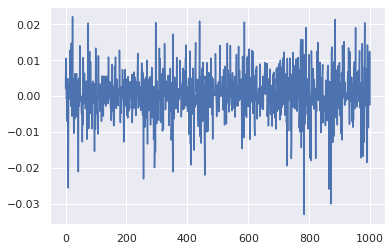

In [8]:
y_T = df.to_numpy(dtype = np.float32)
plt.plot(y_T)

# Simulate data

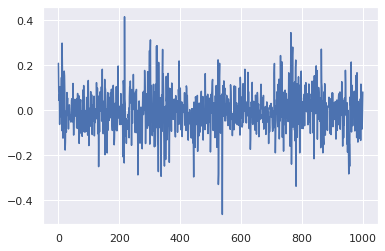

In [11]:
burnin_simulation = 2_000

y_T_simulated = simulate_data(T = T + burnin_simulation, alpha  = -0.5, delta = 0.9, sigma_nu = 0.4, burnin = burnin_simulation)
plt.plot(y_T_simulated)

# Abstract gibbs

In [12]:
class AbstractGibbs(abc.ABC):

    def __init__(self,
                num_iter: int, 
                verbose: int,
                prior: Dict[str, Any], 
                prior_parameters: Dict[str, float],
                data: pd.Series,
                dir_figs: str
                ):
        """
        prior: {'parameter_name': scipy_distribution}
        prior_parameters: {'parameter_of_prior': float, value}
        """

        self.num_iter = num_iter
        self.verbose = verbose
        self.prior = prior
        self.prior_parameters = prior_parameters
        self.data = copy.deepcopy(data)
        self.y_T = copy.deepcopy(data)
        self.dir_figs = dir_figs

        

    

    @abc.abstractmethod
    def update_theta(self, theta, x):
        """
        theta contains the parameters that are to be updated
        """
        pass
    
    @abc.abstractmethod
    def step0(self):
        pass


    def print_progress(self, n):
        params = self.chain[0].keys()
        msg = 'Iteration %i' % n
        if hasattr(self, 'nacc') and n > 0:
            msg += ', acc. rate=%.3f' % (self.nacc / n)
        for p in params:
            if isinstance(self.chain[n][p], (pd.Series, list, np.ndarray)):
                msg += ', %s=%s' % (p, self.chain[n][p][0])
            else:    
                msg += ', %s=%s' % (p, self.chain[n][p])
        print(msg)
        


    def plot_theta_distributions(self, burnin):
        
        parameter_names = list(self.chain[0].keys())
        fig, axes = plt.subplots(len(parameter_names), 1, figsize = (10, 5 * len(parameter_names)) )
        for axis, name in enumerate(parameter_names):
            f = lambda x: x[name]
            component = np.array(list(map(f, self.chain)))[burnin:]
            if len(component.shape) > 1:
                component = copy.deepcopy(component[:, 0])
            sns.distplot(component, ax = axes[axis])
            axes[axis].set_title(name)
        plt.savefig(self.dir_figs + f'/distributions.png')


    def plot_theta_paths(self, burnin = 0):
        
        parameter_names = list(self.chain[0].keys())
        fig, axes = plt.subplots(len(parameter_names), 1, figsize = (10, 5 * len(parameter_names)))
        for axis, name in enumerate(parameter_names):
            f = lambda x: x[name]
            component = np.array(list(map(f, self.chain)))[burnin:]
            if len(component.shape) > 1:
                component = copy.deepcopy(component[:, 0])
            axes[axis].plot(list(range(len(component))), component)
            axes[axis].set_title(name)
        plt.savefig(self.dir_figs + f'/paths.png')


    def print_theta_estimators(self, burnin):
        parameter_names = list(self.chain[0].keys())
        estimates = {}
        stds = {}
        for axis, name in enumerate(parameter_names):
            f = lambda x: x[name]
            component = np.array(list(map(f, self.chain)))[burnin:]
            mean = np.mean(component)
            std = np.std(component)
            estimates[name] = mean
            stds[name] = std
            print(f'estimate for {name}: {mean} with std {std}.')
        return estimates, stds


    def step(self, n):
        self.chain.append(self.update_theta(self.chain[n-1], self.data, n))
    


    @timeit
    def __call__(self):
        for n in range(self.num_iter):
            if n == 0:
                self.step0()
            else:
                self.step(n)
            if self.verbose and n % self.verbose == 0:
                self.print_progress(n)



# Basic SVM

In [351]:
class BasicGibbs(AbstractGibbs):


    def __init__(self,
                num_iter,
                verbose,
                prior, 
                prior_parameters,
                data,
                N,
                dir_figs,
                sample_method,
                sigma_kernel = None,
                plot_p_q = False,
                ):
        super().__init__(num_iter, verbose, prior, prior_parameters, data, dir_figs)
        self.T = data.shape[0]
        self.N = N

        self.chain = []

        self.rejected = []
        self.repeated = []

        self.repeated_mh_method = []

        self.c = []

        self.sample_method = sample_method
        self.sigma_kernel = sigma_kernel

        self.plot_p_q = plot_p_q

        assert not (sample_method == 'full_metropolis' and sigma_kernel is None)


    def plot_rejection_repeat_rates(self):
        
        fig, axes = plt.subplots(2, 1, figsize = (10, 5 * 2))

        axes[0].plot(list(range(len(self.rejected))), self.rejected)
        axes[0].set_title('number of rejections')

        axes[1].plot(list(range(len(self.repeated))), np.array(self.repeated) )
        axes[1].set_title('repeats')
        plt.savefig(self.dir_figs + f'/rejection_repeat_rates.png')

        
        
    def update_theta(self, theta, x, n):
        """
        theta: dictionary containing the parameters to be updated.
        """
        new_theta = theta.copy()


        # update omega := (alpha, delta, sigma_nu) via linear regression
        
        h_t = copy.deepcopy(theta['ln_h_T'])
        ln_h_T = copy.deepcopy(theta['ln_h_T'])
        alpha, delta, sigma_nu = new_theta['alpha'], new_theta['delta'], new_theta['sigma_nu']
        ln_h_0 = (-alpha + ln_h_T[0] - sigma_nu * stats.norm().rvs()) / delta

        h_t_moins_1 = np.roll(h_t , 1)
        h_t_moins_1[0] = ln_h_0

        delta = new_theta['delta']
        alpha = new_theta['alpha']
        sigma_nu = new_theta['sigma_nu']


        


        # delta

        new_beta2_delta = 1/ (  ((h_t_moins_1 ** 2 ).sum()) / (sigma_nu ** 2)   + 1 / self.prior_parameters['beta2_delta'] )
        new_alpha_delta = new_beta2_delta * (  ( (h_t-alpha) * h_t_moins_1  ).sum() / (sigma_nu ** 2) + self.prior_parameters['alpha_delta']/ self.prior_parameters['beta2_delta']   )

        cnt = 0
        
        while True:
            delta = stats.norm(new_alpha_delta, new_beta2_delta).rvs()

            if -1 < delta < 1:
                break
            cnt += 1
            if cnt > 15:
                raise ValueError('failing to sample delta.')
        new_theta['delta'] = delta
            


        # alpha

        new_beta2_alpha = 1 / ( self.T / (sigma_nu**2) + 1 / self.prior_parameters['beta2_alpha'])

        new_alpha_alpha = new_beta2_alpha * ( ( h_t - delta * h_t_moins_1).sum() / sigma_nu**2 + self.prior_parameters['alpha_alpha'] / self.prior_parameters['beta2_alpha'])

        alpha = stats.norm(new_alpha_alpha, new_beta2_alpha).rvs() 
        new_theta['alpha'] = alpha

        # sigma_nu
        new_alpha_sigma = self.prior_parameters['alpha_sigma'] + self.T / 2
        new_beta2_sigma = self.prior_parameters['beta2_sigma'] + 0.5 * ((h_t - alpha - delta * h_t_moins_1) ** 2).sum()
        sigma_nu = np.sqrt(stats.invgamma( a = new_alpha_sigma, scale = new_beta2_sigma).rvs())
        new_theta['sigma_nu'] = sigma_nu


        # update ln_h_T via rejection sampling and MH
        ln_h_T = copy.deepcopy(new_theta['ln_h_T'])
        new_ln_h_T = copy.deepcopy(new_theta['ln_h_T'])
        for t, _ in enumerate(ln_h_T):
            # define q_t := q(h_t|....)
            if t == 0:
                # we sample h_0 using the time reversibility of the AR(1) as mentionned in the paper
                ln_h_0 = (-alpha + ln_h_T[t] - sigma_nu * stats.norm().rvs())/delta
                mu_t = (alpha * (1 - delta) + delta * (ln_h_T[t+1] + ln_h_0))/(1 + delta ** 2)
            if t == self.T-1:
                # same code in fact, it turns out it is exactly the same case, but with the forward sense of the AR(1)
                ln_h_T_T = alpha + delta * ln_h_T[t] + sigma_nu * stats.norm().rvs()
                mu_t = (alpha * (1 - delta) + delta * (ln_h_T[t-1] + ln_h_T_T))/(1 + delta ** 2) # there is a '-' instead of a '+'
            else:
                mu_t = (alpha * (1 - delta) + delta * (ln_h_T[t+1] + ln_h_T[t-1]))/(1 + delta ** 2)
            sigma = np.sqrt(sigma_nu ** 2 / (1 + delta ** 2))


            if self.sample_method == 'full_metropolis':
                p = lambda h: ((1 / h) ** 1.5) * np.exp( - (self.y_T[t] ** 2 ) / (2 * h) - ((np.log(h) - mu_t) ** 2 )/ (2 * sigma ** 2))
                
                count_repeated_mh_method = 0
                x = np.exp(ln_h_T[t])
                for _ in range(self.N):
                    z = stats.norm(loc = x, scale = self.sigma_kernel).rvs()
                    while z < 0:
                        z = stats.norm(loc = x, scale = self.sigma_kernel).rvs()
                    u = stats.uniform().rvs()
                    if u < p(z) / p(x):
                        x = z 
                    else :
                        count_repeated_mh_method += 1
                self.repeated_mh_method.append(count_repeated_mh_method)

                new_ln_h_T[t] = np.log(x)



            
            elif self.sample_method == 'rejection_metropolis':
                phi_1 = -.5
                phi_LN = (1 - 2 * np.exp(sigma ** 2)) / (1 - np.exp(sigma ** 2))
                phi = phi_1 + phi_LN - 1
                
                theta_1t = self.y_T[t] ** 2 / 2
                theta_LNt = (phi_LN - .5) * np.exp(mu_t + .5 * sigma ** 2)
                theta_t = theta_1t + theta_LNt
                


                q = stats.invgamma(a = phi, loc = 0, scale = theta_t)
                p = lambda h: ((1 / h) ** 1.5) * np.exp( - (self.y_T[t] ** 2 ) / (2 * h) - ((np.log(h) - mu_t) ** 2 )/ (2 * sigma ** 2))

                # approximation of the mode of q
                x = np.linspace(0, 100, num = 10_000) 
                q_x = q.pdf(x)
                p_x = p(x)
                idx_mode_of_q = np.argmax(q_x)
                
                if self.plot_p_q:
                    y = np.linspace(0, 100, num = 400)
                    plt.plot(x, q_x)
                    plt.plot(x, p_x)
                    #plt.savefig(osp.join(self.dir_figs, 'dist_q') + '/' + f'q_{t}_{n}')
                    #plt.savefig(osp.join(self.dir_figs, 'dist_q') + '/' + f'q_p_{t}_{n}')
                    plt.xlabel('x', fontsize = 15)
                    plt.ylabel('pdf', fontsize = 15)
                    plt.legend(['q', 'p'], fontsize = 15)
                    plt.show()


                c = 1.1 * p(x[idx_mode_of_q]) / q.pdf(x[idx_mode_of_q]) # we take 1.15 because previous approximation is not really good
                self.c.append(c)
                

                # algo of rejection sampling and Metropolis Hasting.

                # initialization
                h_t_n = np.exp(ln_h_T[t]) # h index t, nth draw.

                for _ in range(self.N):
                    # draw from q: 
                    retained = False
                    count_rejected = -1
                    while not retained:
                        count_rejected += 1 
                        h_candidate = q.rvs()
                        u = stats.uniform().rvs()

                        if u < p(h_candidate) / (c * q.pdf(h_candidate)): # no need to put the min in practice because we deal with probas.
                            retained = True
                        
                        if count_rejected > 15:
                            print(p(h_candidate) / (c * q.pdf(h_candidate)))
                            print('Stuck in rejection sampling')

                            if count_rejected > 1_000: # safety
                                raise ValueError('reach max number of rejections')
                    self.rejected.append(count_rejected)

                    # now entering Metropolis-Hasting step because the candidate is retained (otherwise rejection).
                    # this step is described in the paper 'Accept–reject Metropolis–Hastings sampling and marginal likelihood estimation'.
                    # it is different from usual MH steps because of the non-domiance in the acception/ rejection step.
                    # indeed p(h) <= c * q(h) does not all for every h. 
                    h_t_n_plus_1 = h_candidate
                    u = stats.uniform().rvs()

                    count_repeated = 0
                    if p(h_t_n) <= c * q.pdf(h_t_n): # if the domination holds for the previous (old) h_t_n
                        new_ln_h_T[t] = np.log(h_t_n_plus_1) # then we do not repeat the old h_t_n
                    elif p(h_t_n_plus_1) <= c * q.pdf(h_t_n_plus_1): # if the domination does not holds for the previous (old) h_t_n but holds for the new
                        if u <  c * q.pdf(h_t_n) / p(h_t_n):
                            new_ln_h_T[t] = np.log(h_t_n_plus_1) # then we do not repeat the old h_t_n with proba c * q.pdf(h_t_n) / p(h_t_n)
                        else:
                            count_repeated += 1
                    else: # then it is basic MH step.
                        if u <  p(h_t_n_plus_1) * q.pdf(h_t_n) / (p(h_t_n) * q.pdf(h_t_n_plus_1)):
                            new_ln_h_T[t] = np.log(h_t_n_plus_1) # then we do not repeat the old h_t_n with proba c * q.pdf(h_t_n) / p(h_t_n)
                        # in other cases we do not update
                        else:
                            count_repeated += 1
                        
                        self.repeated.append(count_repeated)
                
            else:
                raise ValueError('the indicated sample method in incorrect')
            

        new_theta['ln_h_T'] = copy.deepcopy(new_ln_h_T)

        return new_theta


    def step0(self):
        """
        in this function, one should make use of self.prior for simulation in state 0.
        """

        th_0 = {parameter: prior.rvs() for parameter, prior in self.prior.items()}
            

        # the provided distribution was for sigma_nu ** 2
        th_0['sigma_nu'] = np.sqrt(th_0['sigma_nu'])

      
        # special case here as we want to truncate to ensure stationarity (the while loop will take a reasonable time depending on the prior):
        while th_0['delta'] >= 1 or th_0['delta'] <= -1:
            th_0['delta'] = self.prior['delta'].rvs()
        

        # special case for 'ln_h_T' whose prior depends on other parameters is a np.array of length T.
        th_0['ln_h_T'] = np.zeros((2*self.T, ))
        ln_h_0 = 0 
        th_0['ln_h_T'][0] = ln_h_0
        for t in range(1, 2*self.T):
            th_0['ln_h_T'][t] = th_0['alpha'] + th_0['delta'] * th_0['ln_h_T'][t-1] + th_0['sigma_nu'] * stats.norm().rvs()
        th_0['ln_h_T'] = th_0['ln_h_T'][self.T:]


        self.chain.append(th_0)


 

In [352]:
nu_0 = 1 
s_0 = 5e-1 # The value from the article provides a non-flat prior, contrary to what is says. Therefore we adapted it.

In [353]:
prior = {'sigma_nu': stats.invgamma(a = nu_0, loc = 0, scale = nu_0 * s_0**2 / 2),
                'alpha': stats.norm(loc = 0, scale = .1), 
                'delta': stats.norm(loc = 0.5, scale = 0.5), # we take the uniform over [.5, 1], even if we know it should be around 0.9. The article propose N(0, 10) but then we would need to reject the delta outside [0, 1], and N(0, 10) is flat over [0,1] so no big difference.

                }

In [354]:
prior_parameters = { 
                'alpha_alpha' : 0,
                'beta2_alpha' : 0.1,
                'alpha_delta' : 0.5,
                'beta2_delta' : 0.5,
                'alpha_sigma' : nu_0 ,
                'beta2_sigma' : nu_0 * s_0**2 / 2,
                }

The parameter sample_method can be either 'full_metropolis' to sample h by Metropolis-Hasting only, or 'rejection_metropolis' to use the method from the article that combines both acceptation/rejection sampling and Metropolis-Hasting.

Only the first element of ln_h_T is printed.

## Rejection sampling and Metropolis Hasting algorithm

### Bayesian inference on simulated data

Here we check the method still works by recovering the parameters of simulated data: alpha  = -0.5, delta = 0.9, sigma_nu = 0.4 .

Be carefull that sometimes, with a bad initialization, delta might converge to zero. If it happens, just re-run the two cells below.

In the article they run the algorithms for over 30k iterations, so more iterations are needed to get smoothed posteriors in the plot below. However we can see that the Gibbs sampler converges for less than 1k iterations for this model.

In [355]:
gibbs_simulated_data = BasicGibbs(num_iter= 2_500, 
                                    verbose = 2, 
                                    prior = prior, 
                                    prior_parameters = prior_parameters,
                                    data= y_T_simulated[:90], 
                                    N = 1, 
                                    dir_figs = dir_figs, 
                                    sample_method = 'rejection_metropolis', 
                                    plot_p_q = False
                                    )

In [356]:
gibbs_simulated_data()

Iteration 0, sigma_nu=0.7331442669041343, alpha=0.14561695739311145, delta=0.5575177454717141, ln_h_T=0.9121069529289447
0.6545603475594303
Stuck in rejection sampling
Iteration 2, sigma_nu=0.7177309555466461, alpha=0.16758747641381147, delta=0.4188223952625942, ln_h_T=1.0839099503022307
Iteration 4, sigma_nu=0.6709900537232425, alpha=0.14251990213582555, delta=0.37560903495641673, ln_h_T=0.3421597763046349
Iteration 6, sigma_nu=0.6522911759347828, alpha=0.15650630306042368, delta=0.30410279168230897, ln_h_T=0.3528175730428623
Iteration 8, sigma_nu=0.5588927501094154, alpha=0.156162648966992, delta=0.17689926273505963, ln_h_T=0.6140110136012462
Iteration 10, sigma_nu=0.5315418955325969, alpha=0.055101312915221745, delta=0.31223809665526847, ln_h_T=-0.24413124474254114
Iteration 12, sigma_nu=0.5019354147659466, alpha=0.040517146160629194, delta=0.1955834173379684, ln_h_T=-0.39542642228114067
Iteration 14, sigma_nu=0.40176096602019373, alpha=-0.03360733655103951, delta=0.0328402724119632

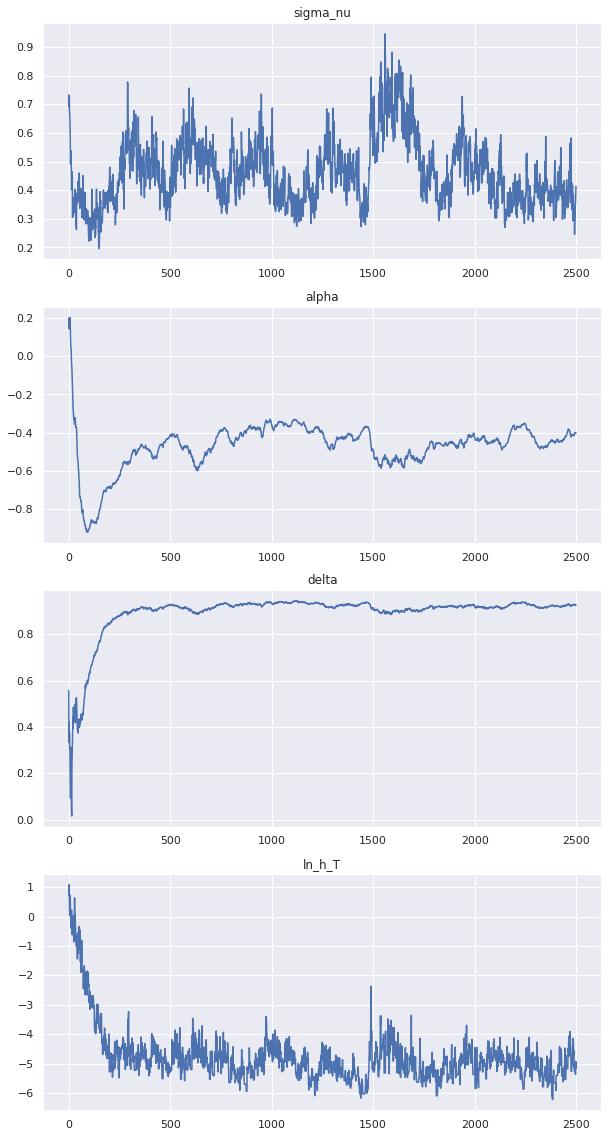

In [358]:
gibbs_simulated_data.plot_theta_paths(0)

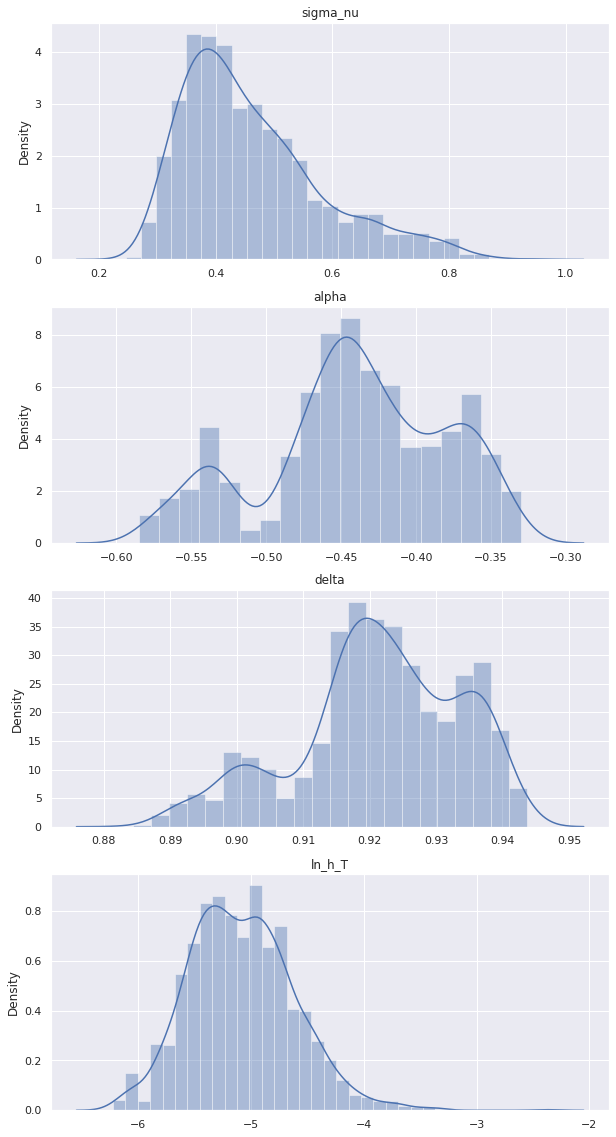

In [360]:
gibbs_simulated_data.plot_theta_distributions(burnin = 1_000)

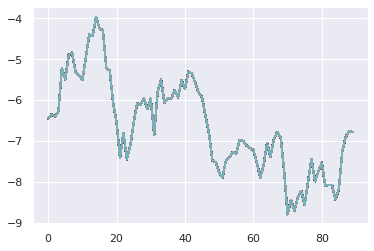

In [43]:
for x in gibbs_simulated_data.chain:
  y = x["ln_h_T"]
  plt.plot(y)
plt.show()

The repeat rate is not always one, it is just ocilating so fast we could think it is constant in the next plot.

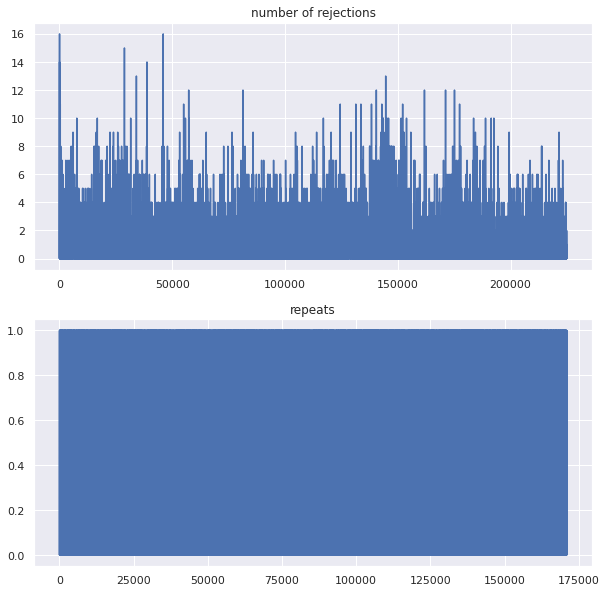

In [361]:
gibbs_simulated_data.plot_rejection_repeat_rates()

We can find here their means.

In [362]:
np.mean(gibbs_simulated_data.repeated)

0.39435210699054

In [363]:
np.mean(gibbs_simulated_data.rejected)

0.1858832421857632

In [364]:
estimates, stds = gibbs_simulated_data.print_theta_estimators(burnin = 1_000)

estimate for sigma_nu: 0.46237383285913786 with std 0.12098424929189673.
estimate for alpha: -0.44097478412762636 with std 0.06011505590496932.
estimate for delta: 0.9212772962560234 with std 0.012295996348350257.
estimate for ln_h_T: -5.681316119804603 with std 0.8622833554493124.


### Real data

Here it might take a bit longer to converge so we increased the number of iterations. We can recover values that are similar to that of the article, but the shapes of the posteriors look a bit less like Gaussian and truncated Gaussians because real data does not follow exactly a SVM process. But still, one can recognize a Gaussian shape.

In [410]:
gibbs = BasicGibbs(num_iter= 5_000, 
                                    verbose = 2, 
                                    prior = prior, 
                                    prior_parameters = prior_parameters,
                                    data= y_T[:90], 
                                    N = 1, 
                                    dir_figs = dir_figs, 
                                    sample_method = 'rejection_metropolis', 
                                    plot_p_q = False
                                    )

In [411]:
gibbs()

Iteration 0, sigma_nu=0.5025494874343216, alpha=0.06861061454654953, delta=0.23477208123753773, ln_h_T=0.7295169388921996
Iteration 2, sigma_nu=0.5679350628776982, alpha=0.026651306698755033, delta=0.1531223602415625, ln_h_T=1.136686527640551
Iteration 4, sigma_nu=0.5341640178339186, alpha=-0.06162668933206523, delta=0.1294673278840188, ln_h_T=-0.4391646840300483
Iteration 6, sigma_nu=0.44866487660069326, alpha=-0.15763201173215446, delta=0.20473711772097022, ln_h_T=-0.3279084220112532
Iteration 8, sigma_nu=0.37909266069074143, alpha=-0.2261892232156438, delta=0.28872606547265894, ln_h_T=-0.3910311056586112
Iteration 10, sigma_nu=0.31671088840945427, alpha=-0.2596570807088002, delta=0.38240096099953885, ln_h_T=-0.3013227167009042
Iteration 12, sigma_nu=0.2633036624721498, alpha=-0.3047385917288939, delta=0.43404550775698614, ln_h_T=-0.7484070226145395
Iteration 14, sigma_nu=0.25369933821866986, alpha=-0.3399658763676263, delta=0.44024518764247267, ln_h_T=-0.3254418786915659
Iteration 1

sigma_nu [0.50254949 0.5731455  0.56793506 ... 0.84765195 0.86073485 0.82338765]
alpha [ 0.06861061  0.0259693   0.02665131 ... -0.42377302 -0.41654959
 -0.41871905]
delta [0.23477208 0.25580035 0.15312236 ... 0.95425503 0.95084196 0.95384357]
ln_h_T [  0.72951694   0.30952045   1.13668653 ... -12.09129255 -12.09129255
 -12.09129255]


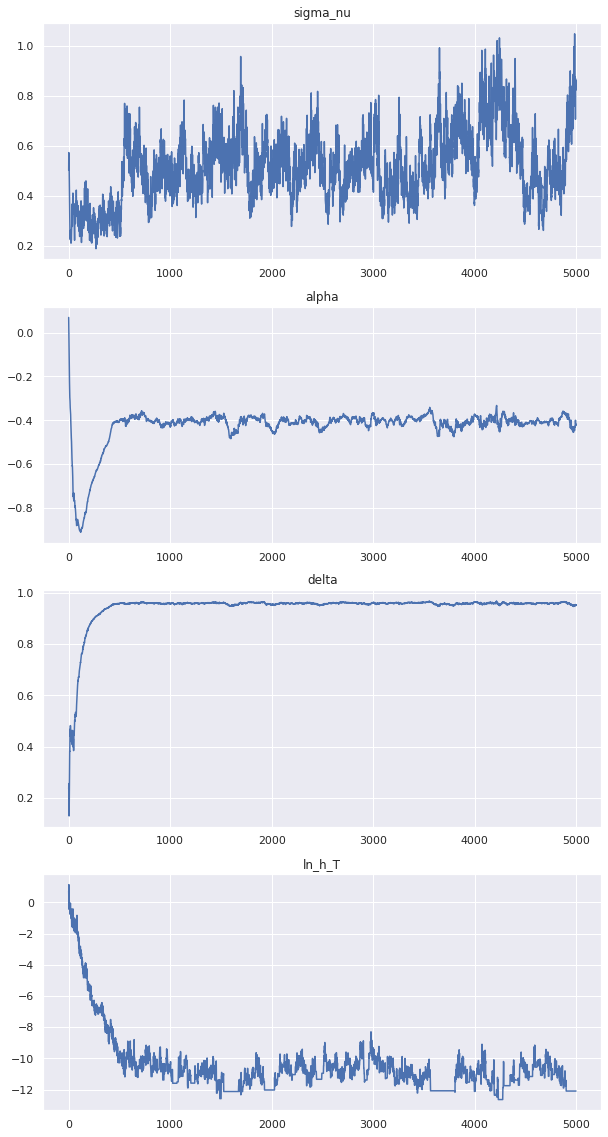

In [412]:
gibbs.plot_theta_paths(0)

[0.55958538 0.53616406 0.53567463 ... 0.84765195 0.86073485 0.82338765]
sigma_nu [0.55958538 0.53616406 0.53567463 ... 0.84765195 0.86073485 0.82338765]
[-0.4306413  -0.42425811 -0.42394016 ... -0.42377302 -0.41654959
 -0.41871905]
alpha [-0.4306413  -0.42425811 -0.42394016 ... -0.42377302 -0.41654959
 -0.41871905]
[0.95814183 0.958549   0.95773941 ... 0.95425503 0.95084196 0.95384357]
delta [0.95814183 0.958549   0.95773941 ... 0.95425503 0.95084196 0.95384357]
[[-10.39919976 -10.01961301 -10.56581099 ... -10.66909676 -10.93943602
  -10.9843614 ]
 [-10.39919976 -10.01961301 -10.56581099 ... -10.63369477 -10.93943602
  -10.8095364 ]
 [-10.39919976 -10.01961301 -10.56581099 ... -10.96258221 -10.93943602
  -10.8095364 ]
 ...
 [-12.09129255 -10.94950426  -9.90509258 ...  -9.77757364  -9.10507376
   -8.96632216]
 [-12.09129255 -10.94950426  -9.74957347 ...  -9.77757364  -9.10507376
   -8.75926136]
 [-12.09129255 -10.94950426  -9.42902627 ...  -8.97319184  -9.6934901
   -8.69430038]]
ln_h_T

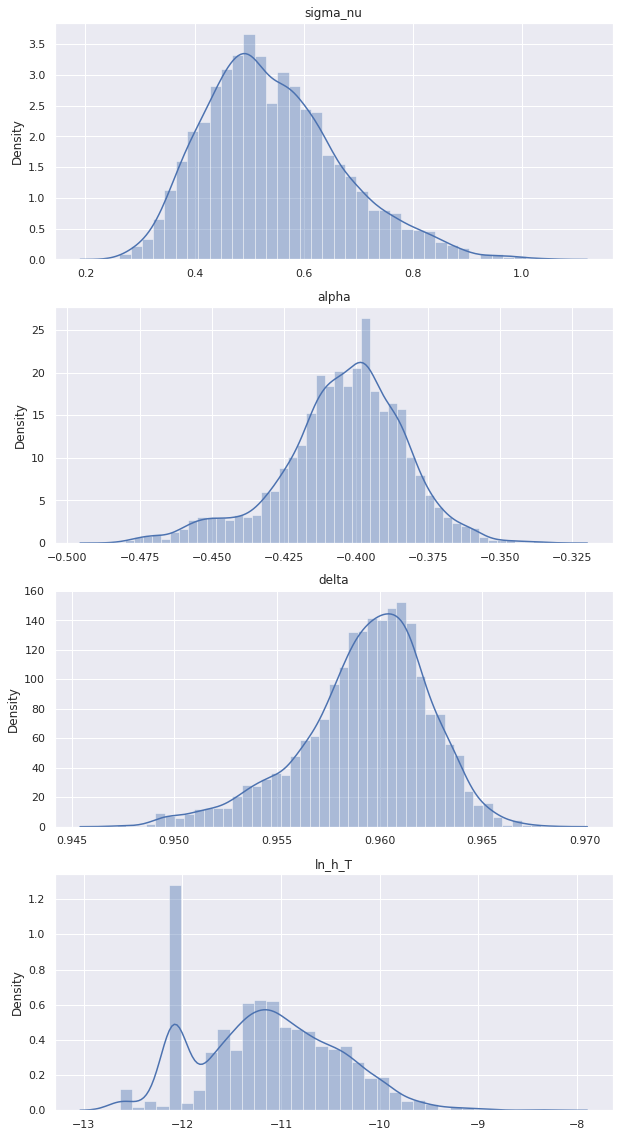

In [413]:
gibbs.plot_theta_distributions(burnin = 1_000)

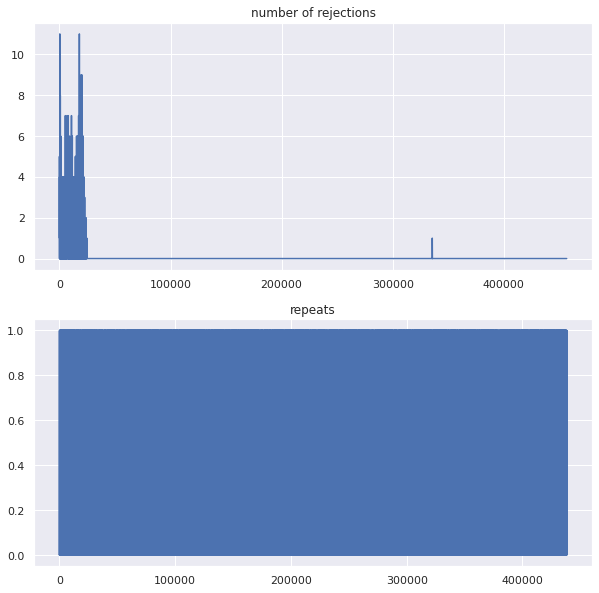

In [414]:
gibbs.plot_rejection_repeat_rates()

In [415]:
np.mean(gibbs.repeated)

0.46504708381535204

In [416]:
np.mean(gibbs.rejected)

0.022755340673200727

In [418]:
estimates, stds = gibbs.print_theta_estimators(burnin = 1_000)

estimate for sigma_nu: 0.5451815863896526 with std 0.12581956968010274.
estimate for alpha: -0.4046129299807204 with std 0.021683639657221723.
estimate for delta: 0.9592945370416491 with std 0.003129634913407309.
estimate for ln_h_T: -10.353906604502527 with std 0.7283897010244488.


## Metropolis-Hasting Method 

works fine with (N >= 20).

Here we check the method still works by recovering the parameters of simulated data.

In [432]:
np.random.seed(seed = 10)

In [ ]:
gibbs_full_metropolis_simulated_data = BasicGibbs(num_iter= 2_000, 
                                                    verbose = 2, 
                                                    prior = prior, 
                                                    prior_parameters = prior_parameters,
                                                    data= y_T_simulated[:90], 
                                                    N = 20, 
                                                    dir_figs = dir_figs, 
                                                    sample_method = 'full_metropolis', 
                                                    sigma_kernel = 2., 
                                                    plot_p_q = False
                                                    )


In [ ]:
gibbs_full_metropolis_simulated_data()

In [ ]:
gibbs_full_metropolis_simulated_data.plot_theta_paths(0)

In [ ]:
gibbs_full_metropolis_simulated_data.plot_theta_distributions(burnin = 600)

# Fat tails

In [365]:
class FatTailsGibbs(BasicGibbs):


    def __init__(self,
                num_iter,
                verbose,
                prior, 
                prior_parameters,
                data,
                N,
                dir_figs,
                sample_method,
                sigma_kernel = None,
                plot_p_q = False,
                ):
        super().__init__(num_iter, verbose, prior, prior_parameters, data, N, dir_figs, sample_method, sigma_kernel, plot_p_q)


        assert not (sample_method == 'full_metropolis' and sigma_kernel is None)




    def plot_rejection_repeat_rates(self):
        
        fig, axes = plt.subplots(2, 1, figsize = (10, 5 * 2))

        axes[0].plot(list(range(len(self.rejected))), self.rejected)
        axes[0].set_title('number of rejections')

        axes[1].plot(list(range(len(self.repeated))), np.array(self.repeated))
        axes[1].set_title('repeat rates')
        plt.savefig(self.dir_figs + f'/rejection_repeat_rates.png')

        
        
    def update_theta(self, theta, x, n):
        """
        theta: dictionary containing the parameters to be updated.
        """
        self.y_T = self.y_T / np.sqrt(theta['lambda_T'])
        theta = copy.deepcopy(super().update_theta(theta, x, n))
        new_theta = copy.deepcopy(theta)
        # we then come back to real y_T, because we have done copy.deepcopy we can do that:
        self.y_T = copy.deepcopy(self.data)

        # update lambda
        lbd_T = np.zeros((self.T, ))
        for t, y in enumerate(self.y_T):
            lbd_T[t] = stats.invgamma(a = (theta['degrees_freedom'] + 1) / 2, scale = ( (y ** 2 / np.exp(theta['ln_h_T'][t])) +  theta['degrees_freedom'] ) / 2 ).rvs()

        new_theta['lambda_T'] = lbd_T


        # update degrees of freedom
        weights = np.zeros((self.prior_parameters['degrees_freedom_sup'] - self.prior_parameters['degrees_freedom_inf']))
        for i, nu in enumerate(range(self.prior_parameters['degrees_freedom_inf'], self.prior_parameters['degrees_freedom_sup'])):
            weights[i] = self.T / 1.73  * (nu/2 * np.log(nu) + np.log(scipy.special.gamma(nu + 1/2 )) -  np.log(scipy.special.gamma(nu/2 )) -   np.log(scipy.special.gamma(1/2 ))  ) - ((nu + 1) / 2) * np.array([np.log(nu + self.y_T[t]**2 / np.exp(theta['ln_h_T'][t])) for t in range(self.T) ]).sum()                           
            # print('444', i, weights[i])
            # print(1, (nu/2 * np.log(nu) + np.log(scipy.special.gamma(nu + 1/2 )) -  np.log(scipy.special.gamma(nu/2 )) -   np.log(scipy.special.gamma(1/2 ))  ))
            # print(2, - ((nu + 1) / 2) * np.array([np.log(nu + self.y_T[t]**2 / np.exp(theta['ln_h_T'][t])) for t in range(self.T) ]).sum()    )
            weights[i] = np.exp(weights[i])
        weights = weights / weights.sum()

        degrees_freedom = np.random.choice(a = np.arange(self.prior_parameters['degrees_freedom_inf'], self.prior_parameters['degrees_freedom_sup']), p = weights)
        new_theta['degrees_freedom'] = degrees_freedom


        return new_theta


    def step0(self):
        """
        in this function, one should make use of self.prior for simulation in state 0.
        """

        th_0 = {parameter: prior.rvs() for parameter, prior in self.prior.items()}
            

        # the provided distribution was for sigma_nu ** 2
        th_0['sigma_nu'] = np.sqrt(th_0['sigma_nu'])

      
        # special case here as we want to truncate to ensure stationarity (the while loop will take a reasonable time depending on the prior):
        while th_0['delta'] >= 1 or th_0['delta'] <= -1:
            th_0['delta'] = prior['delta'].rvs()

        # lamda's prior depends on v
        th_0['lambda_T'] = stats.invgamma(a = th_0['degrees_freedom'] / 2. , loc = 0, scale = th_0['degrees_freedom'] / 2.).rvs(size = self.T)
        
        

        # special case for 'ln_h_T' whose prior depends on other parameters is a np.array of length T.
        th_0['ln_h_T'] = np.zeros((2*self.T, ))
        ln_h_0 = 0 
        th_0['ln_h_T'][0] = ln_h_0
        for t in range(1, 2*self.T): 
            th_0['ln_h_T'][t] = th_0['alpha'] + th_0['delta'] * th_0['ln_h_T'][t-1] + th_0['sigma_nu'] * stats.norm().rvs()
        th_0['ln_h_T'] = th_0['ln_h_T'][self.T:]


        self.chain.append(th_0)


 

In [366]:
nu_0 = 1 
s_0_squared = 5e-1

We call 'degrees_freedom' the number of degrees of freedom of the noise of y_t.

In [367]:
prior = {'sigma_nu': stats.invgamma(a = nu_0, loc = 0, scale = nu_0 * s_0_squared / 2),
                'alpha': stats.norm(loc = 0, scale = .1), 
                'delta': stats.norm(loc = 0.5, scale = 0.5), # we take the uniform over [.5, 1], even if we know it should be around 0.9. The article propose N(0, 10) but then we would need to reject the delta outside [0, 1], and N(0, 10) is flat over [0,1] so no big difference.
                'degrees_freedom': stats.randint(3, 41),

                }

In [368]:
prior_parameters = { 
                'alpha_alpha' : 0,
                'beta2_alpha' : 0.1,
                'alpha_delta' : 0.5,
                'beta2_delta' : 0.5,
                'alpha_sigma' : nu_0 ,
                'beta2_sigma' : nu_0 * s_0_squared / 2,
                'degrees_freedom_inf' : 3,
                'degrees_freedom_sup' : 41

                }

In [369]:
np.random.seed(seed = 10)

In [370]:
gibbs_fat_tails_simulated_data = FatTailsGibbs(num_iter= 2_500, 
                                    verbose = 2, 
                                    prior = prior, 
                                    prior_parameters = prior_parameters,
                                    data= y_T_simulated[:90], 
                                    N = 1, 
                                    dir_figs = dir_figs, 
                                    sample_method = 'rejection_metropolis', 
                                    plot_p_q = False
                                    )

In [371]:
gibbs_fat_tails_simulated_data()

Iteration 0, sigma_nu=0.981239247564826, alpha=0.0037772614402270793, delta=0.43227575422199493, degrees_freedom=31, lambda_T=1.0209106123157043, ln_h_T=0.9817086658188966
Iteration 2, sigma_nu=0.9762546125009702, alpha=-0.07131553398774063, delta=0.3519854978562549, degrees_freedom=40, lambda_T=1.429621774759797, ln_h_T=0.2941291457264853
Iteration 4, sigma_nu=0.8142895462139502, alpha=-0.07639042738057364, delta=0.3383263387900385, degrees_freedom=40, lambda_T=1.5160522665014742, ln_h_T=-0.2471263522327481
Iteration 6, sigma_nu=0.671116083657504, alpha=-0.12634416626753125, delta=0.534922929189387, degrees_freedom=40, lambda_T=1.1179572198025889, ln_h_T=-1.083781602057135
Iteration 8, sigma_nu=0.6671037173667855, alpha=-0.20243471112366201, delta=0.5502971570897726, degrees_freedom=40, lambda_T=1.2902925235924612, ln_h_T=-1.083781602057135
Iteration 10, sigma_nu=0.5881698280414072, alpha=-0.23291260135332667, delta=0.5671592036766657, degrees_freedom=40, lambda_T=0.872893732285312, l

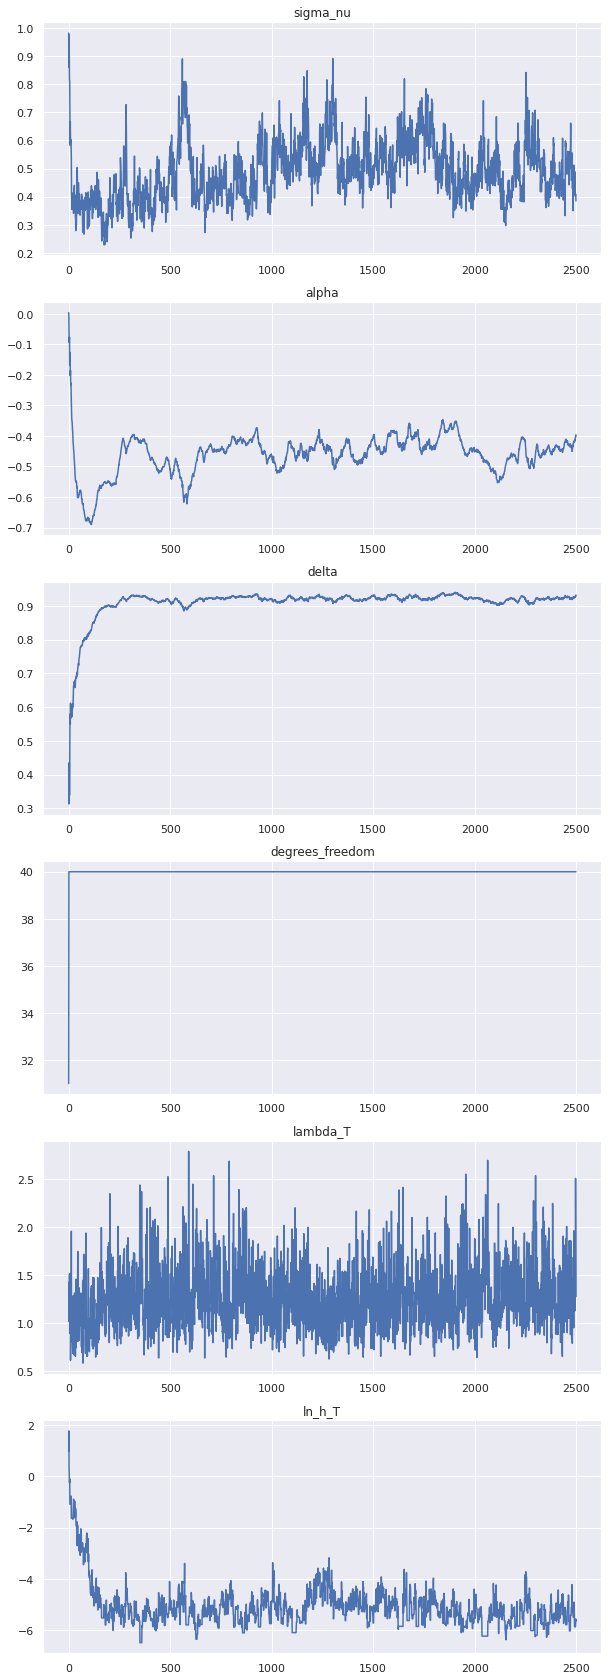

In [372]:
gibbs_fat_tails_simulated_data.plot_theta_paths(0)

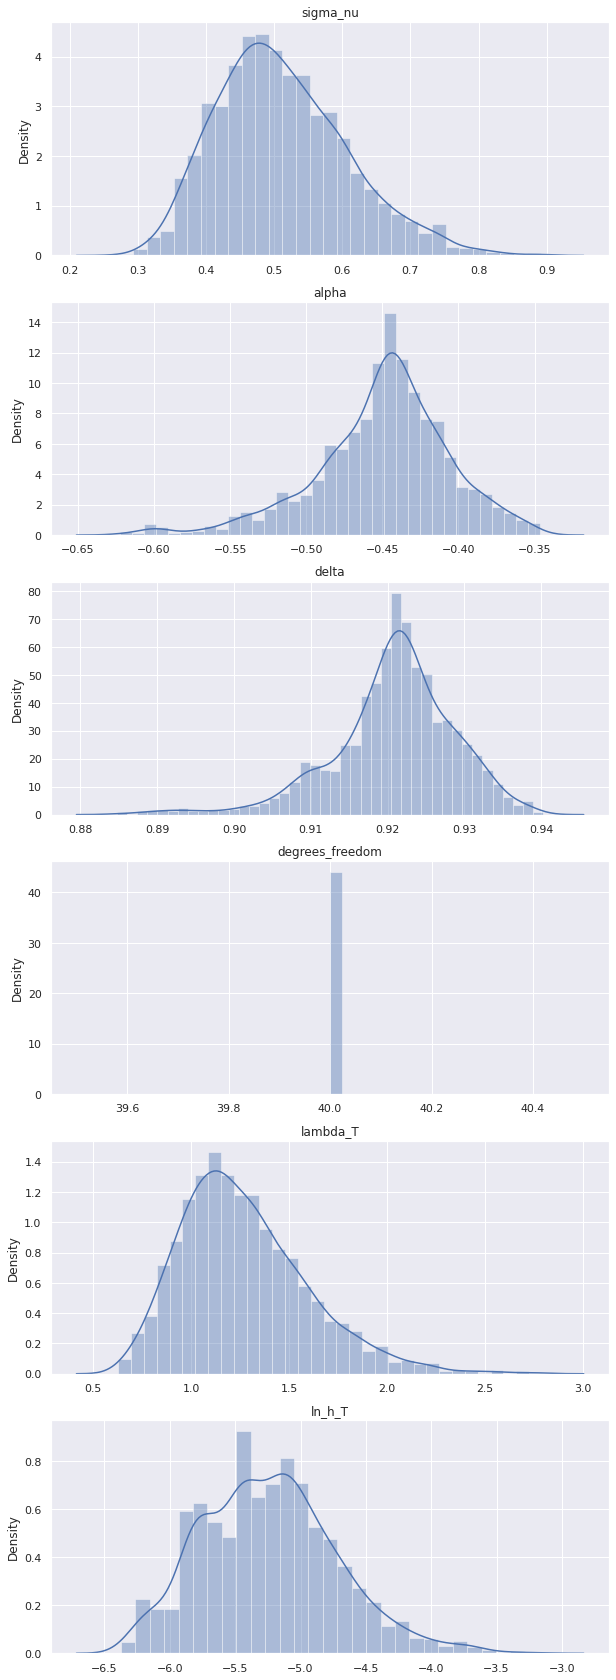

In [373]:
gibbs_fat_tails_simulated_data.plot_theta_distributions(burnin = 500)

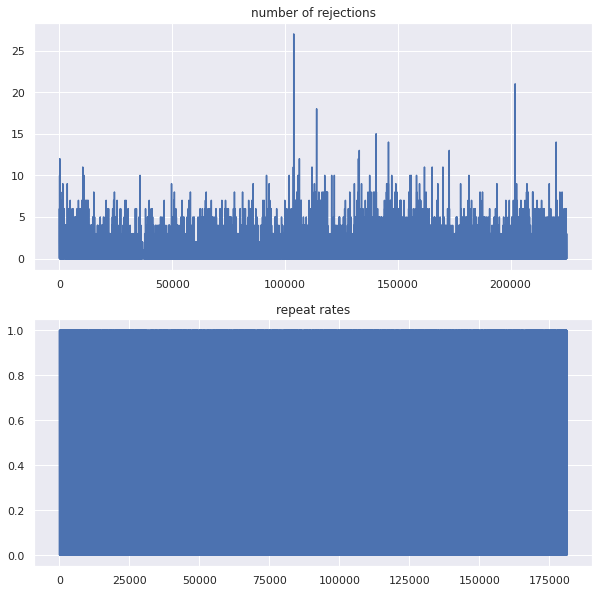

In [375]:
gibbs_fat_tails_simulated_data.plot_rejection_repeat_rates()

In [376]:
np.mean(gibbs_fat_tails_simulated_data.repeated)

0.4205989160788989

In [377]:
np.mean(gibbs_fat_tails_simulated_data.rejected)

0.16370103596994354

In [378]:
estimates, stds = gibbs_fat_tails_simulated_data.print_theta_estimators(burnin = 1_000)

estimate for sigma_nu: 0.5234311311039826 with std 0.08957978642011008.
estimate for alpha: -0.4454441766854393 with std 0.039075176189083974.
estimate for delta: 0.9214657917331345 with std 0.007128020479279667.
estimate for degrees_freedom: 40.0 with std 0.0.
estimate for lambda_T: 1.0648645292093848 with std 0.25298174900812515.
estimate for ln_h_T: -5.775659018388455 with std 0.965591865908934.


# Correralated errors

In [322]:
class CorrelatedGibbs(AbstractGibbs):


    def __init__(self,
                num_iter,
                verbose,
                prior, 
                prior_parameters,
                data,
                N,
                dir_figs,
                sample_method,
                sigma_kernel = None,
                plot_p_q = False,
                ):
        super().__init__(num_iter, verbose, prior, prior_parameters, data, dir_figs)
        self.T = data.shape[0]
        self.N = N

        self.chain = []

        self.rejected = []
        self.repeated = []

        self.repeated_mh_method = []

        self.c = []

        self.sample_method = sample_method
        self.sigma_kernel = sigma_kernel

        self.plot_p_q = plot_p_q

        assert not (sample_method == 'full_metropolis' and sigma_kernel is None)


    def plot_rejection_repeat_rates(self):
        
        fig, axes = plt.subplots(2, 1, figsize = (10, 5 * 2))

        axes[0].plot(list(range(len(self.rejected))), self.rejected)
        axes[0].set_title('number of rejections')

        axes[1].plot(list(range(len(self.repeated))), np.array(self.repeated))
        axes[1].set_title('repeats')
        plt.savefig(self.dir_figs + f'/rejection_repeat_rates.png')

        
        
    def update_theta(self, theta, x, n):
        """
        theta: dictionary containing the parameters to be updated.
        """
        new_theta = theta.copy()




        # sample h_0 (the first element (of index 0) of the list ln_h_T is ln_h_1)

        # update omega := (alpha, delta, sigma_nu) via linear regression
        sigma_nu = (new_theta['psi']**2 + new_theta['big_omega'])**1/2

        h_t = copy.deepcopy(new_theta['ln_h_T'])
        ln_h_T = new_theta['ln_h_T']
        alpha, delta= new_theta['alpha'], new_theta['delta']
        ln_h_0 = (-alpha + ln_h_T[0] - sigma_nu * stats.norm().rvs()) / delta

        h_t_moins_1 = np.roll(new_theta['ln_h_T'].copy(), 1)
        h_t_moins_1[0] = ln_h_0


        # psi, big_omega

        epsilon_t = self.y_T / np.exp(new_theta['ln_h_T']/2)
        u_t =  ln_h_T - (alpha + new_theta['delta']*h_t_moins_1)

        r_t = [ np.matmul( np.reshape([epsilon_t[k], u_t[k]], (-1,1)) , np.reshape([epsilon_t[k], u_t[k]], (1,-1)) ) for k in range(self.T)]

        big_sigma_star = np.cov(epsilon_t, u_t)

        A = np.sum(r_t, axis = 0)

        a_11 = A[0,0]
        a_12 = A[0,1]
        a_22 = A[1,1]
        a_22_1 = a_22-a_12**2/a_11



        psi_tilde = (a_12 + prior_parameters['p_0']*psi_0) / (a_11 + prior_parameters['p_0'])


        # big_omega

        new_alpha_omega = prior_parameters['alpha_omega'] + self.T - 1
        new_beta2_omega = prior_parameters['beta2_omega'] + a_22_1

        big_omega = stats.invgamma( a = new_alpha_omega, scale = 1/new_beta2_omega).rvs()
        new_theta['big_omega'] = big_omega


        # psi  

        psi = stats.norm(psi_tilde, new_theta['big_omega']/(a_11+ prior_parameters['p_0'])).rvs()
        new_theta['psi'] = psi

        sigma_nu = (psi**2 + big_omega)**1/2
        rho = psi / sigma_nu


        # delta

        new_beta2_delta = 1/ (  ((h_t_moins_1 ** 2 ).sum()) / (sigma_nu ** 2)   + 1 / prior_parameters['beta2_delta'] )
        new_alpha_delta = new_beta2_delta * (  ( (h_t-alpha) * h_t_moins_1  ).sum() / (sigma_nu ** 2) + prior_parameters['alpha_delta']/ prior_parameters['beta2_delta']   )

        cnt = 0
        
        while True:
            delta = stats.norm(new_alpha_delta, new_beta2_delta).rvs()
            
            if -1 < delta < 1:
                break
            cnt += 1
            if cnt > 15:
                raise ValueError('failing to sample delta.')
        new_theta['delta'] = delta
            


        # alpha
        new_beta2_alpha = 1 / ( self.T / (sigma_nu**2) + 1 / prior_parameters['beta2_alpha'])

        new_alpha_alpha = new_beta2_alpha * ( ( h_t - delta * h_t_moins_1).sum() / sigma_nu**2 + prior_parameters['alpha_alpha'] / prior_parameters['beta2_alpha'])

        alpha = stats.norm(new_alpha_alpha, new_beta2_alpha).rvs() 

        new_theta['alpha'] = alpha

        


        # update ln_h_T via rejection sampling and MH
        ln_h_T = copy.deepcopy(new_theta['ln_h_T'])
        for t, _ in enumerate(ln_h_T):

            epsilon_T_plus_1, u_T_plus_1 = np.random.multivariate_normal([0,0], big_sigma_star)
            
            # define q_t := q(h_t|....)
            if t == 0:
                # we sample h_0 using the time reversibility of the AR(1) as mentionned in the paper

                ln_h_0 = (-alpha + ln_h_T[0] - u_T_plus_1)/delta

                mu_t = (alpha * (1 - delta) + delta * (ln_h_T[t+1] + ln_h_0))/(1 + delta ** 2)

                phi_LN = (1-2*np.exp( big_omega/(1+delta**2)))/(1-np.exp( big_omega/(1+delta**2)))
                phi_t = psi * delta * self.y_T[t+1] / big_omega * np.exp(ln_h_T[t+1])**(-0.5) + phi_LN + 0.5
                epsilon_T_plus_1 = self.y_T[t+1] / np.exp(ln_h_T[t+1]/2)
                phi_1= delta * psi * self.y_T[t+1] / big_omega / np.exp(ln_h_T[t]/2)

            if t == self.T-1:
                # same code in fact, it turns out it is exactly the same case, but with the forward sense of the AR(1)

                ln_h_T_T = alpha + delta * ln_h_T[t] + u_T_plus_1
                mu_t = (alpha * (1 - delta) + delta * (ln_h_T[t-1] + ln_h_T_T))/(1 + delta ** 2) # there is a '-' instead of a '+'

                y_t_plus_1 = np.exp(ln_h_T_T/2) *  epsilon_T_plus_1

                phi_LN = (1-2*np.exp( big_omega/(1+delta**2)))/(1-np.exp( big_omega/(1+delta**2)))
                phi_t = psi * delta * y_t_plus_1 / big_omega * np.exp(ln_h_T_T)**(-0.5) + phi_LN + 0.5

                phi_1 = delta * psi *  y_t_plus_1 / big_omega / np.exp(ln_h_T_T/2)
            else:
                mu_t = (alpha * (1 - delta) + delta * (ln_h_T[t+1] + ln_h_T[t-1]))/(1 + delta ** 2)

                phi_LN = (1-2*np.exp( big_omega/(1+delta**2)))/(1-np.exp( big_omega/(1+delta**2)))
                phi_t = psi * delta * self.y_T[t+1] / big_omega * np.exp(ln_h_T[t+1])**(-0.5) + phi_LN + 0.5

                epsilon_T_plus_1 = self.y_T[t+1] / np.exp(ln_h_T[t+1]/2)

                phi_1 = delta * psi * self.y_T[t+1] / big_omega / np.exp(ln_h_T[t]/2)



            if self.sample_method == 'full_metropolis': 
                p = lambda h: ((1 / h) ** (1.5+phi_1)) * np.exp( - (self.y_T[t] ** 2 ) / (2 * h) * (1+ psi**2 / big_omega) - ((np.log(h) - mu_t) ** 2 )/ (2 * big_omega / (1+delta **2)) + psi * self.y_T[t] / np.exp(ln_h_T[t]/2) * u_t / big_omega )
                
                
                count_repeated_mh_method = 0
                x = np.exp(ln_h_T[t])
                for _ in range(self.N):
                    z = stats.norm(loc = x, scale = self.sigma_kernel).rvs()
                    while z < 0:
                        z = stats.norm(loc = x, scale = self.sigma_kernel).rvs()
                    u = stats.uniform().rvs()
                    if u < p(z) / p(x):
                        x = z 
                    else :
                        count_repeated_mh_method += 1
                self.repeated_mh_method.append(count_repeated_mh_method)

                ln_h_T[t] = np.log(x)


            
            elif self.sample_method == 'rejection_metropolis':

                theta_t = self.y_T[t]**2 / 2 * (1+ psi**2/ big_omega) + (phi_LN-1) * np.exp(mu_t + 0.5 *  big_omega / (1+delta**2))

                #calculer S

                u_t =  ln_h_T - (alpha + new_theta['delta']*h_t_moins_1)

                p = lambda h: ((1 / h) ** (1.5 + phi_1)) * np.exp( - (self.y_T[t] ** 2 ) / (2 * h) * (1+ psi**2 / big_omega) - ((np.log(h) - mu_t) ** 2 )/ (2 * big_omega / (1+delta **2)) + psi * self.y_T[t] / h**0.5 * u_t[t] / big_omega )

                x = np.linspace(0.00001, 100, num = 10_000) 
                p_x = p(x)

                abs_mode_p = x[np.argmax(p_x)]

                f = lambda x : u_t[t] * x**1/2
                

                dist = 0.1

                s = (f(abs_mode_p * (1+dist)) - f(abs_mode_p * (1-dist))) / (2*dist*abs_mode_p)

                theta_t_star = theta_t - s*psi*self.y_T[t]/ big_omega

                q = stats.invgamma( a = phi_t, scale = theta_t_star)

                # approximation of the mode of q

                q_x = q.pdf(x)

                idx_mode_of_q = np.argmax(q_x)
                


                if self.plot_p_q:
                    y = np.linspace(0, 100, num = 400)
                    plt.plot(x, q_x)
                    plt.plot(x, p_x)
                    #plt.savefig(osp.join(self.dir_figs, 'dist_q') + '/' + f'q_{t}_{n}')
                    #plt.savefig(osp.join(self.dir_figs, 'dist_q') + '/' + f'q_p_{t}_{n}')
                    plt.xlabel('x', fontsize = 15)
                    plt.ylabel('pdf', fontsize = 15)
                    plt.legend(['q', 'p'], fontsize = 15)
                    plt.show()

                c = 1.1 * p(x[idx_mode_of_q]) / q.pdf(x[idx_mode_of_q]) # we take 1.15 because previous approximation is not really good
                self.c.append(c)
                

                # algo of rejection sampling and Metropolis Hasting.

                # initialization
                h_t_n = np.exp(ln_h_T[t]) # h index t, nth draw.

                for _ in range(self.N):
                    # draw from q: 
                    retained = False
                    count_rejected = -1
                    while not retained:
                        count_rejected += 1 
                        h_candidate = q.rvs()
                        u = stats.uniform().rvs()

                        if u < p(h_candidate) / (c * q.pdf(h_candidate)): # no need to put the min in practice because we deal with probas.
                            retained = True
                        
                        if count_rejected > 15:
                            print(p(h_candidate) / (c * q.pdf(h_candidate)))
                            print('Stuck in rejection sampling')

                            if count_rejected > 10_000: # safety
                                raise ValueError('reach max number of rejections')
                        self.rejected.append(count_rejected)

                    # now entering Metropolis-Hasting step because the candidate is retained (otherwise rejection).
                    # this step is described in the paper 'Accept–reject Metropolis–Hastings sampling and marginal likelihood estimation'.
                    # it is different from usual MH steps because of the non-domiance in the acception/ rejection step.
                    # indeed p(h) <= c * q(h) does not all for every h. 
                    h_t_n_plus_1 = h_candidate
                    u = stats.uniform().rvs()

                    count_repeated = 0
                    if p(h_t_n) <= c * q.pdf(h_t_n): # if the domination holds for the previous (old) h_t_n
                        ln_h_T[t] = np.log(h_t_n_plus_1) # then we do not repeat the old h_t_n
                    elif p(h_t_n_plus_1) <= c * q.pdf(h_t_n_plus_1): # if the domination does not holds for the previous (old) h_t_n but holds for the new
                        if u <  c * q.pdf(h_t_n) / p(h_t_n):
                            ln_h_T[t] = np.log(h_t_n_plus_1) # then we do not repeat the old h_t_n with proba c * q.pdf(h_t_n) / p(h_t_n)
                        else:
                            count_repeated += 1
                    else: # then it is basic MH step.
                        if u <  p(h_t_n_plus_1) * q.pdf(h_t_n) / (p(h_t_n) * q.pdf(h_t_n_plus_1)):
                            ln_h_T[t] = np.log(h_t_n_plus_1) # then we do not repeat the old h_t_n with proba c * q.pdf(h_t_n) / p(h_t_n)
                        # in other cases we do not update
                        else:
                            count_repeated += 1
                        
                        self.repeated.append(count_repeated)
                
            else:
                raise ValueError('the indicated sample method in incorrect')
            

        new_theta['ln_h_T'] = copy.deepcopy(ln_h_T)

        return new_theta


    def step0(self):
        """
        in this function, one should make use of self.prior for simulation in state 0.
        """

        th_0 = {parameter: prior.rvs() for parameter, prior in self.prior.items()}
            

        # special case here as we want to truncate to ensure stationarity (the while loop will take a reasonable time depending on the prior):
        while th_0['delta'] >= 1 or th_0['delta'] <= 0:
            th_0['delta'] = prior['delta'].rvs()
        

        # psi | big_omega

        th_0['psi'] = stats.norm(prior_parameters['phi_0'], th_0['big_omega'] / prior_parameters['p_0']).rvs()

        big_sigma_star = np.array([[1,th_0['psi']], [th_0['psi'], th_0['big_omega']  + th_0['psi']**2]])

        # special case for 'ln_h_T' whose prior depends on other parameters is a np.array of length T.
        th_0['ln_h_T'] = np.zeros((2*self.T, ))
        ln_h_0 = 0 
        th_0['ln_h_T'][0] = ln_h_0
        for t in range(1, 2*self.T):
            epsilon_T, u_T = np.random.multivariate_normal([0,0], big_sigma_star)
            th_0['ln_h_T'][t] = th_0['alpha'] + th_0['delta'] * th_0['ln_h_T'][t-1] + u_T
        th_0['ln_h_T'] = th_0['ln_h_T'][self.T:]



        self.chain.append(th_0)

In [323]:
nu_0 = 1.
t_0_squared = 5e-1
psi_0 = 0.
p_0 = 2.

In [324]:
prior = {       'alpha': stats.norm(loc = 0, scale = .1), 
                'delta': stats.norm(loc = 0.5, scale = 0.5), # we take the uniform over [.5, 1], even if we know it should be around 0.9. The article propose N(0, 10) but then we would need to reject the delta outside [0, 1], and N(0, 10) is flat over [0,1] so no big difference.
                'big_omega': stats.invgamma(a = nu_0, loc = 0, scale = (nu_0 * t_0_squared)),
                'psi' :  stats.norm(loc = 0.5, scale = 0.5) # placeholder
                }

In [325]:
prior_parameters = { 
                'alpha_alpha' : 0,
                'beta2_alpha' : 0.1,
                'alpha_delta' : 0.5,
                'beta2_delta' : 0.5,
                'alpha_omega' : nu_0 ,
                'beta2_omega' : nu_0 * t_0_squared / 2,
                'p_0' : 2,
                'phi_0' : 0
                }

In [295]:
gibbs_correlated_simulated_data =  CorrelatedGibbs(num_iter= 3_500,
                                                    verbose = 2, 
                                                    prior = prior, 
                                                    prior_parameters = prior_parameters,
                                                    data= y_T_simulated[:90], 
                                                    N = 1, 
                                                    dir_figs = dir_figs, 
                                                    sample_method = 'rejection_metropolis', 
                                                    plot_p_q = False
                                                    )

In [61]:
gibbs_correlated_simulated_data()

Iteration 0, alpha=0.143331445387634, delta=0.6998775103253672, big_omega=0.4741937691051178, psi=0.4512363887806555, ln_h_T=0.08413556396373695
Iteration 2, alpha=0.13127127343100528, delta=0.7969416561925111, big_omega=0.000648941931154221, psi=-0.010888891998450811, ln_h_T=0.7093978247015624
Iteration 4, alpha=0.03182482670637685, delta=0.9263157064137542, big_omega=0.002038823459348077, psi=0.08235025548139602, ln_h_T=0.5298609276771156
Iteration 6, alpha=0.015837355196020367, delta=0.9613273756198316, big_omega=0.0037661037688473836, psi=0.1117950696511383, ln_h_T=0.5343579769070371
Iteration 8, alpha=0.010313164447425277, delta=0.9719324800586955, big_omega=0.004676057662711484, psi=0.09386293908799188, ln_h_T=0.7289269281372904
Iteration 10, alpha=0.009800568122459326, delta=0.9785262569733819, big_omega=0.005155333231531474, psi=0.11268187615434457, ln_h_T=0.8930092665304769
Iteration 12, alpha=0.00873799120538733, delta=0.9807031393983539, big_omega=0.005590856758235614, psi=0

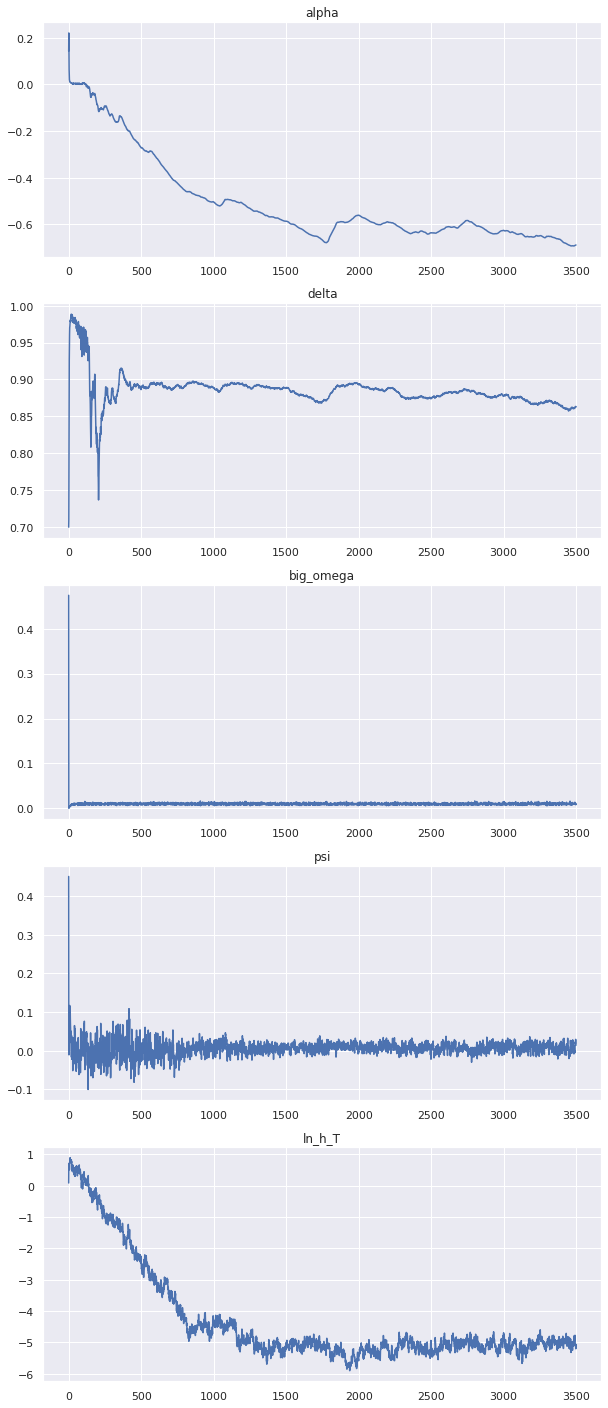

In [62]:
gibbs_correlated_simulated_data.plot_theta_paths(0)

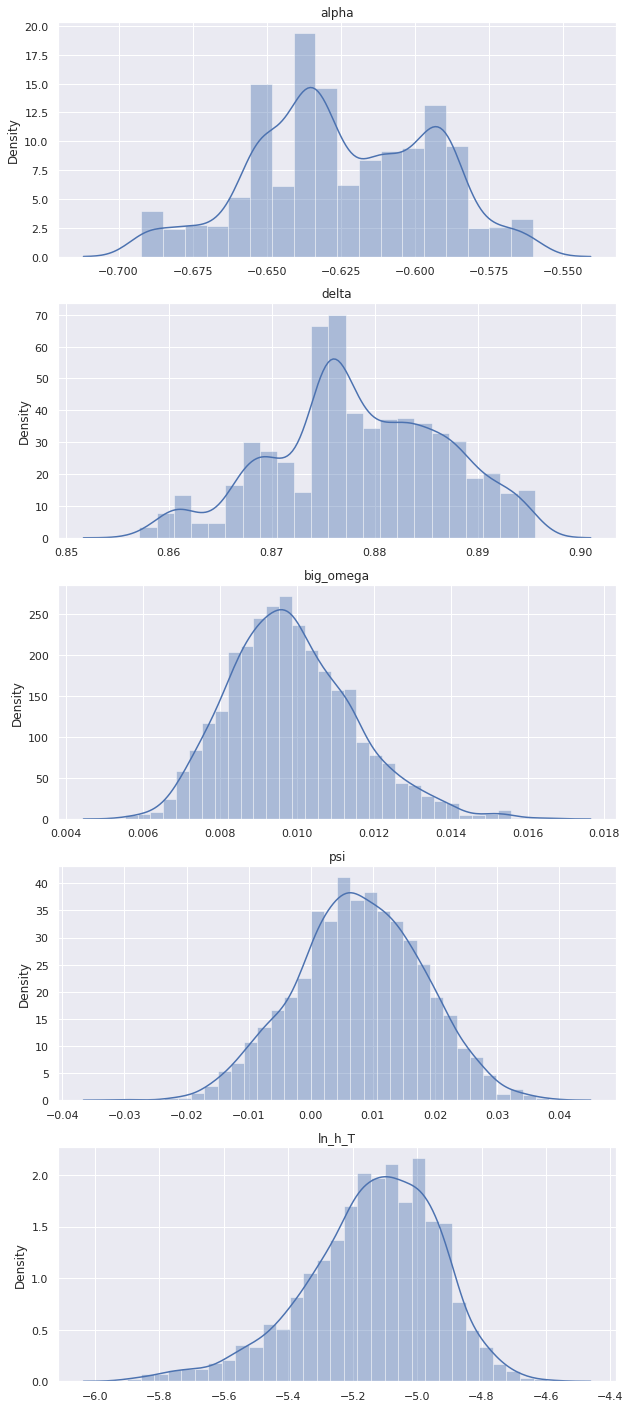

In [63]:
gibbs_correlated_simulated_data.plot_theta_distributions(burnin = 1_500)

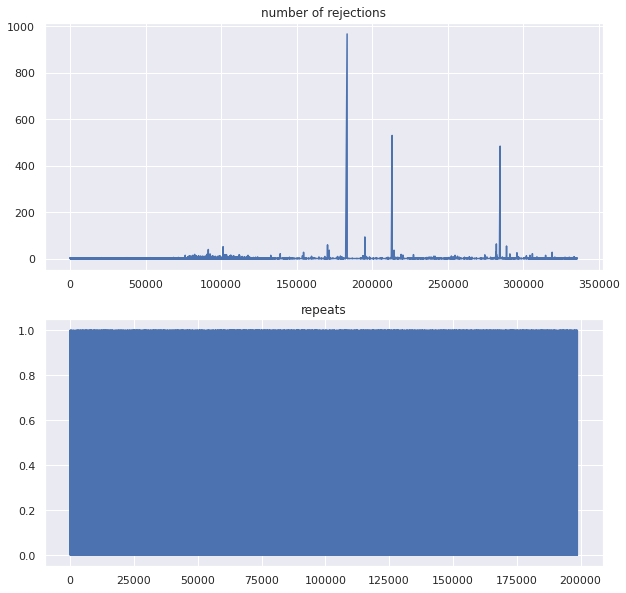

In [64]:
gibbs_correlated_simulated_data.plot_rejection_repeat_rates()

In [65]:
np.mean(gibbs_correlated_simulated_data.repeated)

0.02516644273011368

In [66]:
np.mean(gibbs_correlated_simulated_data.rejected)

2.3037000640252527

In [68]:
estimates, stds = gibbs_correlated_simulated_data.print_theta_estimators(1_500)

estimate for alpha: -0.6243310084398399 with std 0.029715235836133412.
estimate for delta: 0.8785190321037171 with std 0.008287440266913844.
estimate for big_omega: 0.009862212446381993 with std 0.001636127682882052.
estimate for psi: 0.007773099724952919 with std 0.010117290426326687.
estimate for ln_h_T: -5.145720306808255 with std 0.24966394886764823.


# Fat tails with correlated errors

In [326]:
class EnhancedGibbs(CorrelatedGibbs):


    def __init__(self,
                num_iter,
                verbose,
                prior, 
                prior_parameters,
                data,
                N,
                dir_figs,
                sample_method,
                sigma_kernel = None,
                plot_p_q = False,
                ):
        super().__init__(num_iter, verbose, prior, prior_parameters, data, N, dir_figs, sample_method, sigma_kernel, plot_p_q)
     

        assert not (sample_method == 'full_metropolis' and sigma_kernel is None)

        
        
    def update_theta(self, theta, x, n):
        """
        theta: dictionary containing the parameters to be updated.
        """
        new_theta = theta.copy()


        
        self.y_T = self.y_T / np.sqrt(theta['lambda_T'])
        theta = copy.deepcopy(super().update_theta(theta, x, n))
        new_theta = copy.deepcopy(theta)
        # we then come back to real y_T, because we have done copy.deepcopy we can do that:
        self.y_T = copy.deepcopy(self.data)



        # update lambda
        lbd_T = np.zeros((self.T, ))
        for t, y in enumerate(self.y_T):
            lbd_T[t] = stats.invgamma(a = (theta['degrees_freedom'] + 1) / 2, scale = ( (y ** 2 / np.exp(theta['ln_h_T'][t])) +  theta['degrees_freedom'] ) / 2 ).rvs()

        new_theta['lambda_T'] = lbd_T


        # update degrees of freedom
        weights = np.zeros((self.prior_parameters['degrees_freedom_sup'] - self.prior_parameters['degrees_freedom_inf']))
        
        for i, nu in enumerate(range(self.prior_parameters['degrees_freedom_inf'], self.prior_parameters['degrees_freedom_sup'])):
            weights[i] = 10 * (nu/2 * np.log(nu) + np.log(scipy.special.gamma(nu + 1/2 )) -  np.log(scipy.special.gamma(nu/2 )) -   np.log(scipy.special.gamma(1/2 ))  ) - ((nu + 1) / 2) * np.array([np.log(nu + self.y_T[t]**2 / np.exp(theta['ln_h_T'][t])) for t in range(self.T) ]).sum()                           
            weights[i] = np.exp(weights[i])
        weights = weights / weights.sum()

        degrees_freedom = np.random.choice(a = np.arange(self.prior_parameters['degrees_freedom_inf'], self.prior_parameters['degrees_freedom_sup']), p = weights)
        new_theta['degrees_freedom'] = degrees_freedom


        return new_theta
            


    def step0(self):
        """
        in this function, one should make use of self.prior for simulation in state 0.
        """

        th_0 = {parameter: prior.rvs() for parameter, prior in self.prior.items()}
            


        # special case here as we want to truncate to ensure stationarity (the while loop will take a reasonable time depending on the prior):
        while th_0['delta'] >= 1 or th_0['delta'] <= -1:
            th_0['delta'] = prior['delta'].rvs()


           
        # lamda's prior depends on v
        th_0['lambda_T'] = stats.invgamma(a = th_0['degrees_freedom'] / 2. , loc = 0, scale = th_0['degrees_freedom'] / 2.).rvs(size = self.T)
        
        

        # psi | big_omega

        th_0['psi'] = stats.norm(prior_parameters['phi_0'], th_0['big_omega'] / prior_parameters['p_0']).rvs()

        big_sigma_star = np.array([[1,th_0['psi']], [th_0['psi'], th_0['big_omega']  + th_0['psi']**2]])

        # special case for 'ln_h_T' whose prior depends on other parameters is a np.array of length T.
        th_0['ln_h_T'] = np.zeros((2*self.T, ))
        ln_h_0 = 0 
        th_0['ln_h_T'][0] = ln_h_0
        for t in range(1, 2*self.T):
            epsilon_T, u_T = np.random.multivariate_normal([0,0], big_sigma_star)
            th_0['ln_h_T'][t] = th_0['alpha'] + th_0['delta'] * th_0['ln_h_T'][t-1] + u_T
        th_0['ln_h_T'] = th_0['ln_h_T'][self.T:]

        self.f = False
        self.go_boucle = True

        self.chain.append(th_0)

In [327]:
nu_0 = 1.
t_0_squared = 5e-1
psi_0 = 0.
p_0 = 2.

In [328]:
prior = {       
                'degrees_freedom': stats.randint(3, 41),
                'alpha': stats.norm(loc = 0, scale = .1), 
                'delta': stats.norm(loc = 0.5, scale = 0.5), # we take the uniform over [.5, 1], even if we know it should be around 0.9. The article propose N(0, 10) but then we would need to reject the delta outside [0, 1], and N(0, 10) is flat over [0,1] so no big difference.
                'big_omega': stats.invgamma(a = nu_0, loc = 0, scale = (nu_0 * t_0_squared)),
                'psi' :  stats.norm(loc = 0.5, scale = 0.5) # placeholder
                }

In [329]:
prior_parameters = { 
                'alpha_alpha' : 0,
                'beta2_alpha' : 0.1,
                'alpha_delta' : 0.5,
                'beta2_delta' : 0.5,
                'alpha_omega' : nu_0 ,
                'beta2_omega' : nu_0 * t_0_squared / 2,
                'p_0' : 2,
                'phi_0' : 0,
                'degrees_freedom_inf' : 3,
                'degrees_freedom_sup' : 41
                }

## Simulated data

In [174]:
enhanced_gibbs_simulated_data =  EnhancedGibbs(num_iter= 2_000,
                                    verbose = 2, 
                                    prior = prior, 
                                    prior_parameters = prior_parameters,
                                    data= y_T_simulated[:90], 
                                    N = 1, 
                                    dir_figs = dir_figs, 
                                    sample_method = 'rejection_metropolis', 
                                    plot_p_q = False
                                    )

In [175]:
enhanced_gibbs_simulated_data()

Iteration 0, degrees_freedom=27, alpha=-0.19865647335749664, delta=0.31315824794359964, big_omega=0.9331321667326106, psi=-0.6794219221967025, lambda_T=0.8312157192617726, ln_h_T=-1.4742711272679219
Iteration 2, degrees_freedom=40, alpha=-0.212896034446055, delta=0.2958144754926968, big_omega=0.0018171596867280594, psi=-0.05320622313326816, lambda_T=1.2188648044981607, ln_h_T=-0.5822250745159319
Iteration 4, degrees_freedom=40, alpha=-0.20432267182112987, delta=0.4985440318599483, big_omega=0.005505427850120053, psi=-0.007270466519307999, lambda_T=1.2588874525791134, ln_h_T=-0.37962627830779155
Iteration 6, degrees_freedom=40, alpha=-0.19770495966457513, delta=0.5288918767037081, big_omega=0.01068951044751827, psi=0.016375802545581557, lambda_T=0.7241564044603471, ln_h_T=-0.4010224674357646
Iteration 8, degrees_freedom=40, alpha=-0.19216943044348284, delta=0.5591446853221332, big_omega=0.010141574674694885, psi=0.013108421996758744, lambda_T=0.9844153971210756, ln_h_T=-0.47261532480962

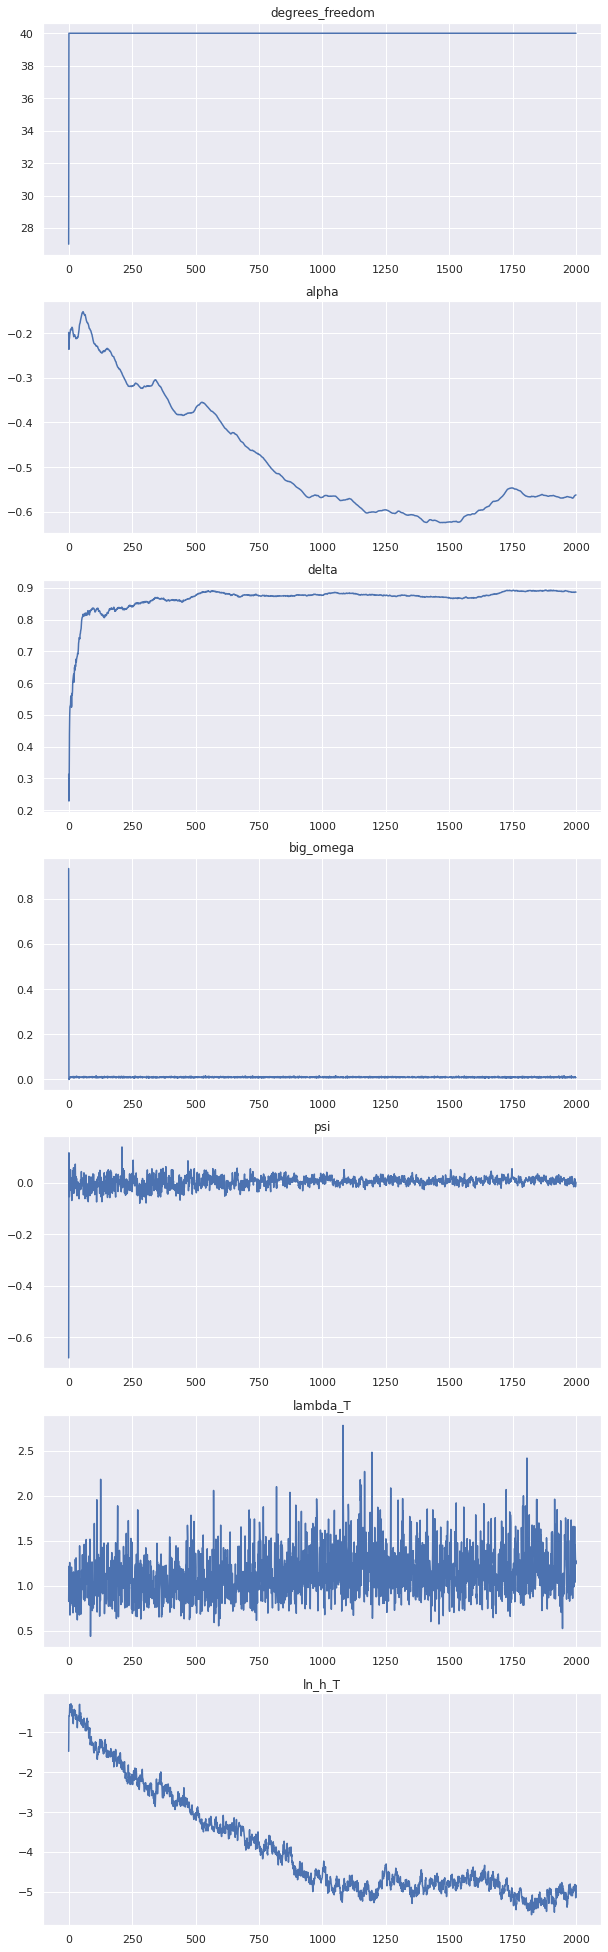

In [176]:
enhanced_gibbs_simulated_data.plot_theta_paths(0)

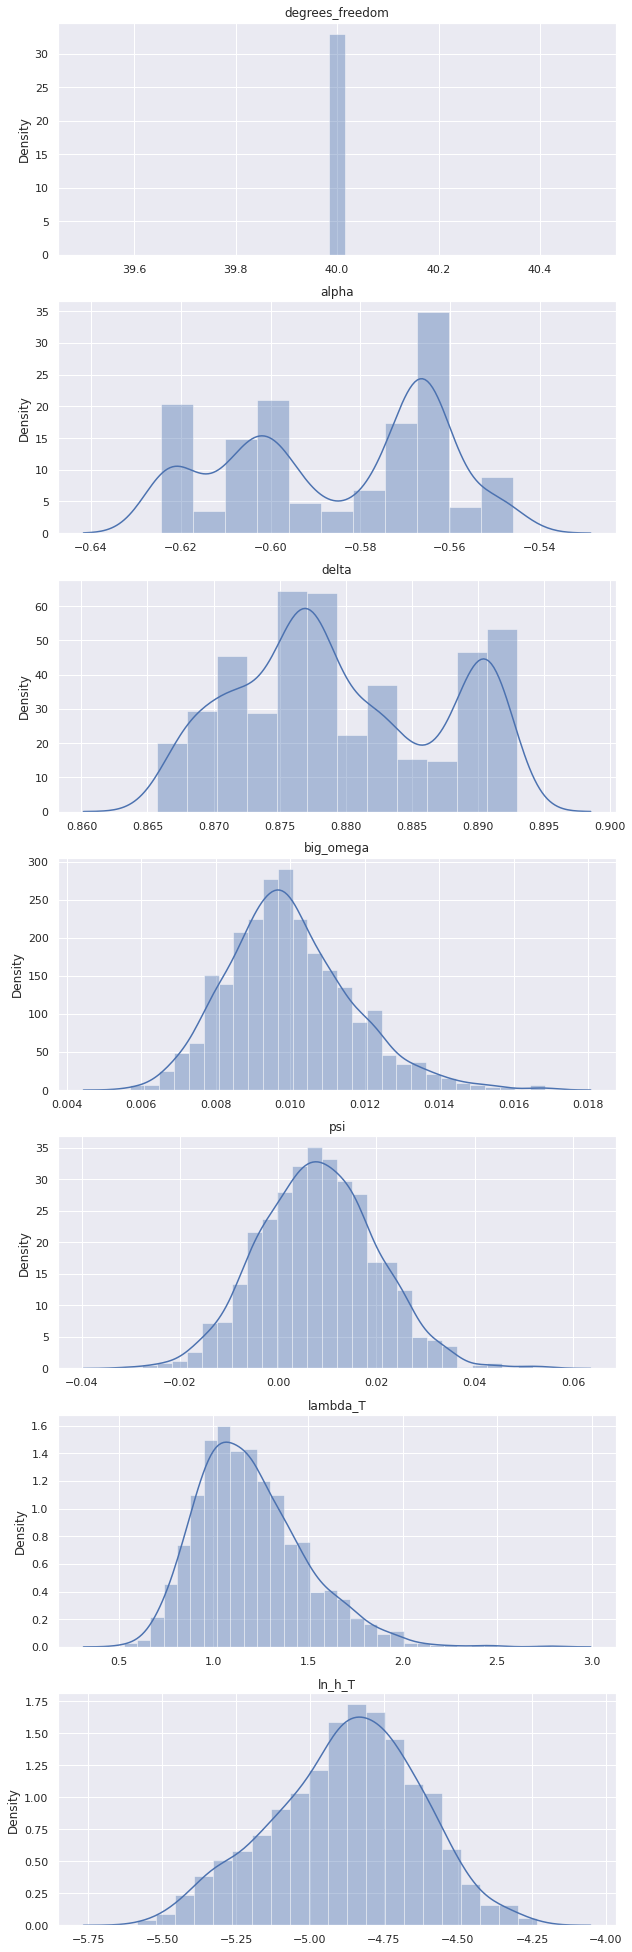

In [191]:
enhanced_gibbs_simulated_data.plot_theta_distributions(burnin = 900)

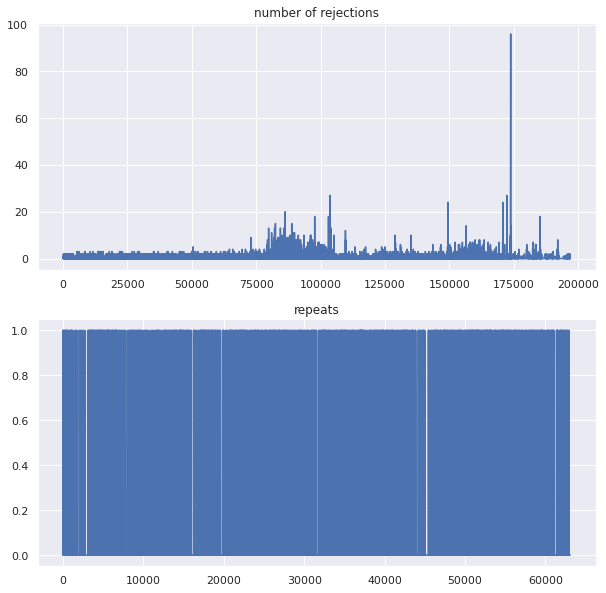

In [184]:
enhanced_gibbs_simulated_data.plot_rejection_repeat_rates()

In [185]:
np.mean(enhanced_gibbs_simulated_data.repeated)

0.021883467761104156

In [186]:
np.mean(enhanced_gibbs_simulated_data.rejected)

0.1633824985402757

In [188]:
estimates, stds = enhanced_gibbs_simulated_data.print_theta_estimators(1_500)

estimate for degrees_freedom: 40.0 with std 0.0.
estimate for alpha: -0.5779922125212681 with std 0.022498925915648817.
estimate for delta: 0.882819563692051 with std 0.00944439057828241.
estimate for big_omega: 0.009829370492488118 with std 0.0017564031410881064.
estimate for psi: 0.00974294702124202 with std 0.011457441989634262.
estimate for lambda_T: 1.04686941932936 with std 0.24596914353576205.
estimate for ln_h_T: -4.947928022513206 with std 0.3104833706229909.


## Real data

In [339]:
np.random.seed(seed = 20)

In [340]:
enhanced_gibbs =  EnhancedGibbs(num_iter= 1_200,
                                    verbose = 2, 
                                    prior = prior, 
                                    prior_parameters = prior_parameters,
                                    data= y_T[:80], 
                                    N = 1, 
                                    dir_figs = dir_figs, 
                                    sample_method = 'rejection_metropolis', 
                                    plot_p_q = False
                                    )

In [341]:
enhanced_gibbs()

Iteration 0, degrees_freedom=38, alpha=0.013276211368003558, delta=0.7471228932092225, big_omega=1.1217509506480219, psi=0.19777739086206222, lambda_T=0.6985534977451158, ln_h_T=0.2047352706693487
Iteration 2, degrees_freedom=3, alpha=-0.06590339759464317, delta=0.8601560185769022, big_omega=0.000627576982335164, psi=0.00430190465523472, lambda_T=3.288520916409807, ln_h_T=-0.901295058915789
Iteration 4, degrees_freedom=3, alpha=-0.03569494096505876, delta=0.9467255321998008, big_omega=0.002587275282576674, psi=0.007604106446600809, lambda_T=26.006850306209987, ln_h_T=-1.034389353113631
Iteration 6, degrees_freedom=3, alpha=-0.026356281168286633, delta=0.9636240701929575, big_omega=0.003649516487990062, psi=-0.017276088829319722, lambda_T=0.7624615570928953, ln_h_T=-1.2395616357554673
Iteration 8, degrees_freedom=3, alpha=-0.02111847396862734, delta=0.9712890724897326, big_omega=0.007045751882874596, psi=0.001887174723306912, lambda_T=1.4685268698621985, ln_h_T=-1.3348636836063574
Itera

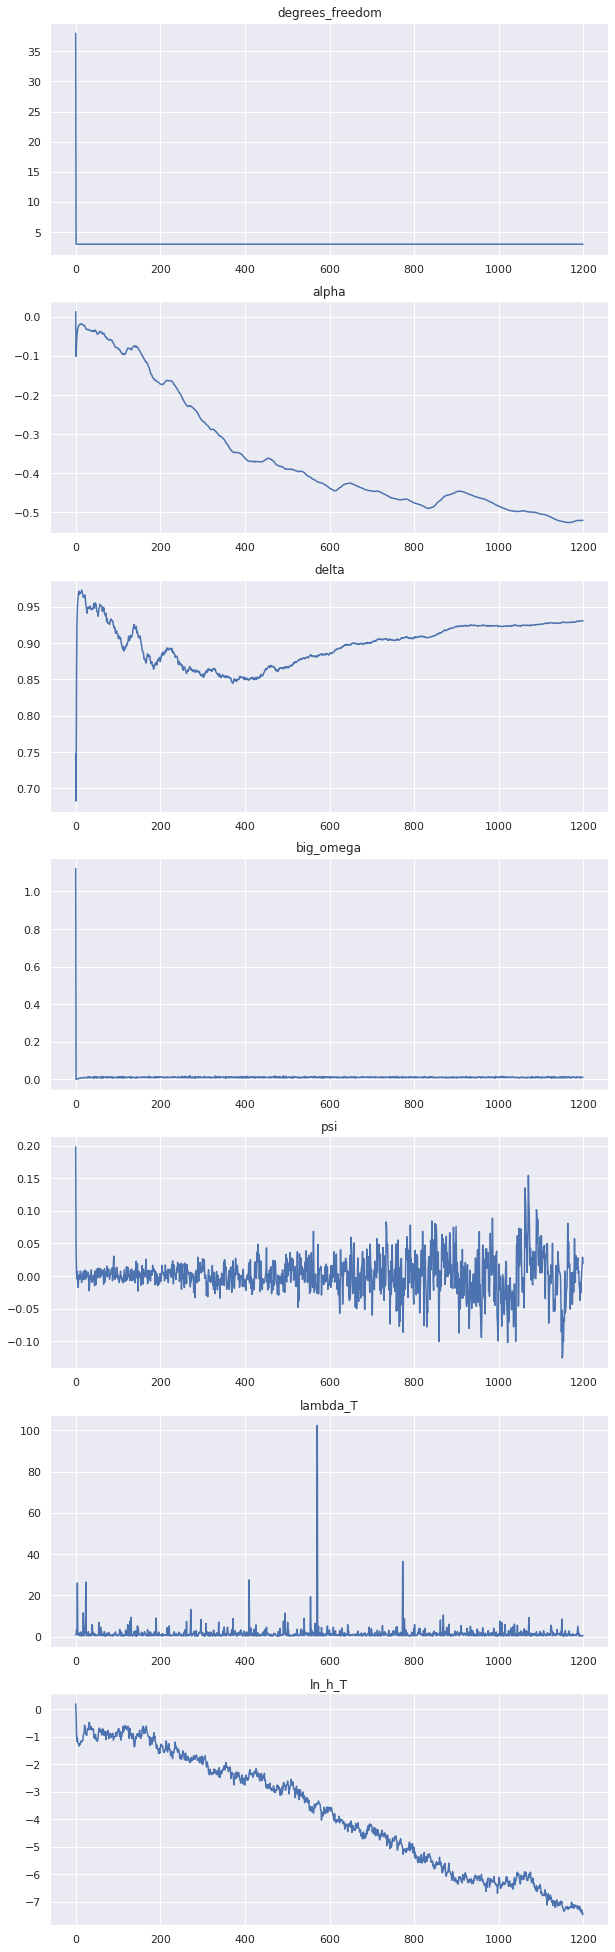

In [342]:
enhanced_gibbs.plot_theta_paths(0)

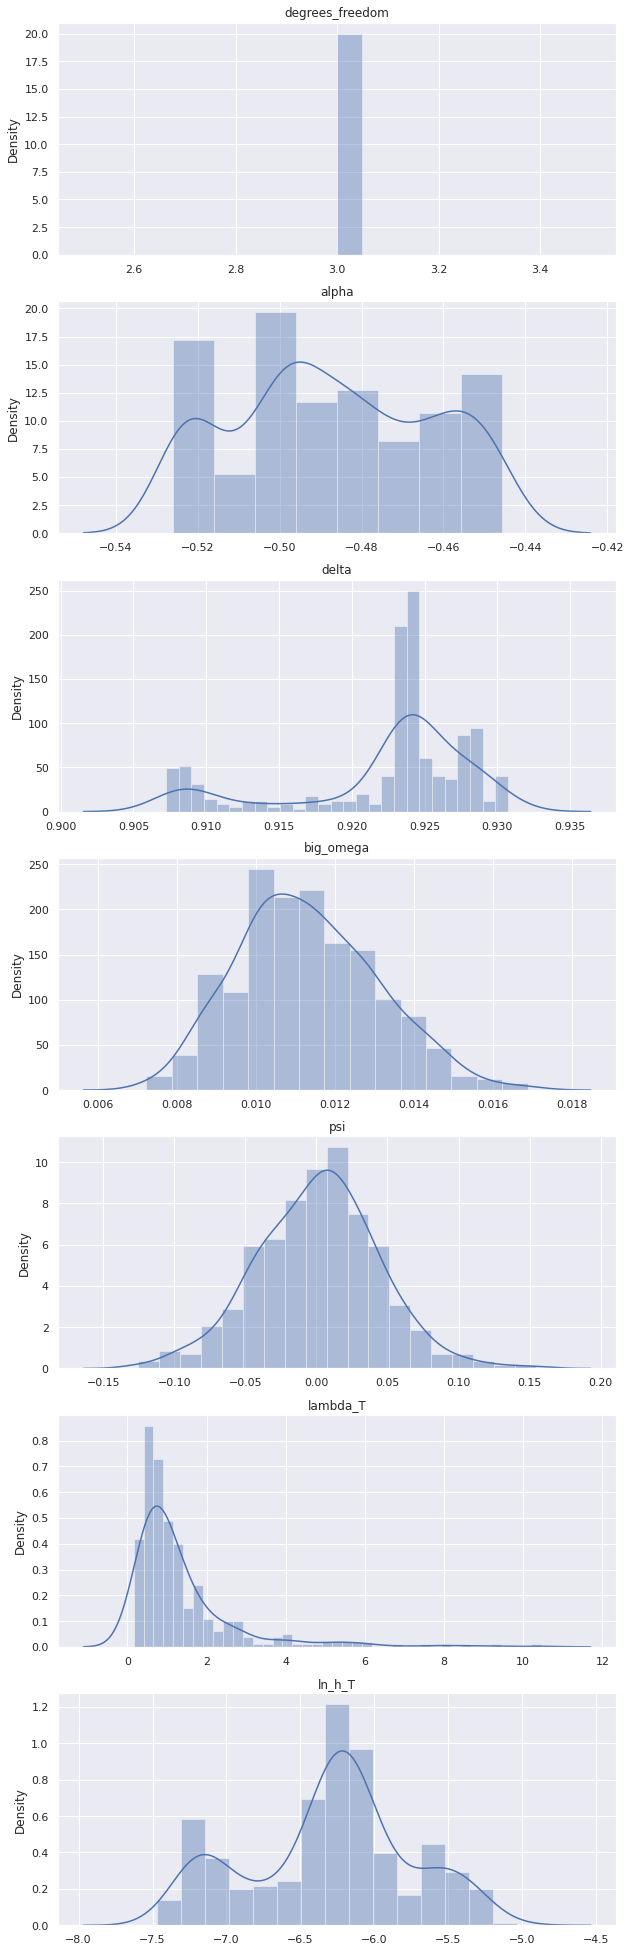

In [380]:
enhanced_gibbs.plot_theta_distributions(burnin = 800)

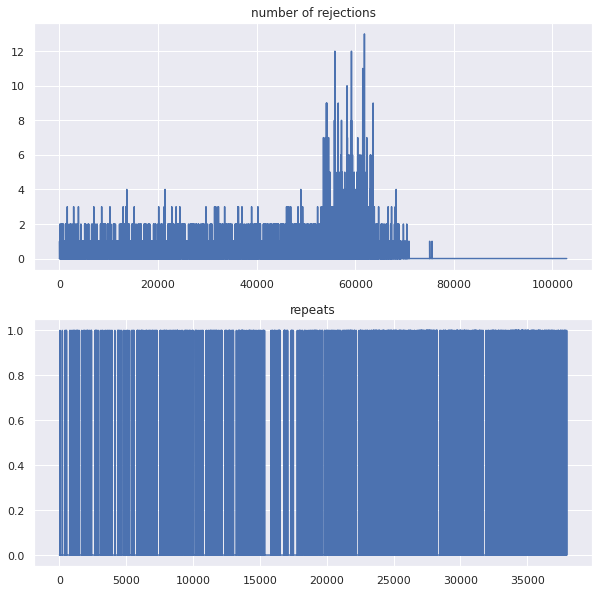

In [344]:
enhanced_gibbs.plot_rejection_repeat_rates()

In [345]:
np.mean(enhanced_gibbs.repeated)

0.02759184103726348

In [346]:
np.mean(enhanced_gibbs.rejected)

0.08964203446499558